<img src="../imgs/NaiveBayesClass.jpeg" style="width:1000px;">

# <center> 07. Understanding Naive Bayes Classifier! </center>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

## Testing unbalanced datasets
We have data from two classes:
    
- **American trilobites**
- **African trilobites**

we will just consider we have one single descriptor, the length. Observe how we build the dataset from the separate files and drop some data to make the exercise with an unbalanced dataset

In [4]:
tr1 = pd.read_csv("../data/trilobites1.csv.gz").sample(frac=.5)
print(tr1.shape)
tr1["label"] = 0
tr2 = pd.read_csv("../data/trilobites2.csv.gz")
print(tr2.shape)
tr2["label"] = 1
d = pd.concat((tr1, tr2)).sample(frac=1).reset_index(drop=True)
del(d["width"])
print d.shape
d.head()

(5000, 2)
(10000, 2)
(15000, 2)


,length,label
0,3.692368,0
1,2.821534,1
2,3.499386,1
3,3.013634,0
4,5.489361,1


Text(0.5,0,u'length')

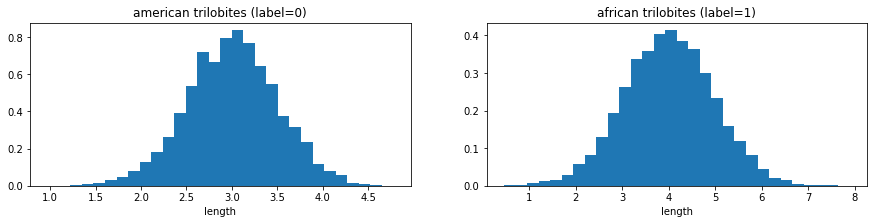

In [5]:
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.hist(d[d.label==0].length.values, bins=30, normed=True)
plt.title("american trilobites (label=0)")
plt.xlabel("length")
plt.subplot(122)
plt.hist(d[d.label==1].length.values, bins=30, normed=True);
plt.title("african trilobites (label=1)")
plt.xlabel("length")


Given a new trilobite $x$ for which we do not know its class, Naive Bayes works as follows to estimate it:
    
- Estimate $P(0|x)$ and $P(1|x)$, the probability of the class being 0 or 1 given the piece of data that we have now ($x$)
- Choose the one with highest probability.

Stop and think from a Bayesian perspective. What information we had before seeing $x$?

Using Bayes:

$$P(0|x) = \frac{P(x|0) P(0)}{P(x)} \;\;\;\;\;\;\;\;P(1|x) = \frac{P(x|1) P(1)}{P(x)}$$

- $P(0)$ and $P(1)$ is the probability of seen an american or an african trilobite
- $P(x|0)$ is the probability of our new trilobite $x$ belonging to class 0. $P(x|1)$ likewise for class 1.
- $P(x)$ is the absolute probability of $x$.

How can we compute each term so that we can estimate $P(0|x)$ and $P(1|x)$?

- for $P(0)$ and $P(1)$ we can use the frequencies of appearance observed in our dataset
- for $P(x|0)$ (or $P(x|1)$ we do not know their distributions (their shape in the charts above). We can **assume they are Gaussian** and use the corresponding PDF to compute probabilities.
- $P(x)$ is very hard, but we do not really need it as it is a common factor of $P(0|x)$ and $P(1|x)$, $\in [0,1]$, and we are only interested in their comparison.

Now, for the Gaussian PDF of $P(x|0)$ we need two parameters: $\mu_0$ and $\sigma_0$, which we can estimate using the corresponding items from our dataset.

Let's say our new trilobite has a length of 3.5

In [6]:
x = 3.5

estimate $P(0)$ and $P(1)$, must correspond to the observed frequencies of our classes

In [6]:
p_0 = np.mean(d.label==0)
p_1 = np.mean(d.label==1)
print "%.3f %.3f"%(p_0, p_1)

0.333 0.667


build the corresponding PDFs for each class using our dataset

In [7]:
lengths0, lengths1 = d[d.label==0].length, d[d.label==1].length

pdf0 = stats.norm(loc=np.mean(lengths0), scale=np.std(lengths0)).pdf
pdf1 = stats.norm(loc=np.mean(lengths1), scale=np.std(lengths1)).pdf


estimate $P(x|0)$ and $P(x|1)$

In [46]:
p_x_given_0 = pdf0(x)
p_x_given_1 = pdf1(x)
print "%.3f %.3f"%(p_x_given_0, p_x_given_1)


0.499 0.362


and finally

In [70]:
p_0_given_x = p_x_given_0 * p_0
p_1_given_x = p_x_given_1 * p_1
print "%.3f %.3f"%(p_0_given_x, p_1_given_x)
print "predicted class:", 0 if p_0_given_x>p_1_given_x else 1

0.166 0.241
predicted class: 1


in fact, plotting $P(0|x)$ and $P(0|x)$ we see we are simply establishing a threshold

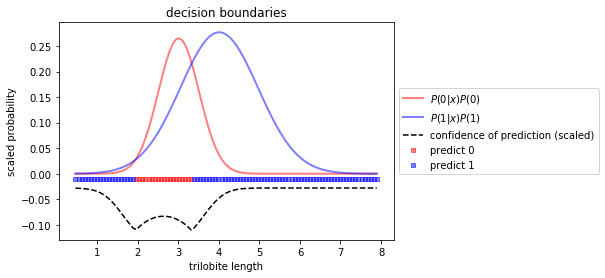

In [13]:
xr = np.linspace(np.min(d.length), np.max(d.length),100)
p_0_given_x = np.r_[[pdf0(i)*p_0 for i in xr]]
p_1_given_x = np.r_[[pdf1(i)*p_1 for i in xr]]
plt.plot(xr, p_0_given_x, lw=2, label="$P(0|x)P(0)$", color="red", alpha=.5)
plt.plot(xr, p_1_given_x, lw=2, label="$P(1|x)P(1)$", color="blue", alpha=.5)

xr0 = xr[(p_0_given_x - p_1_given_x)>=0]
xr1 = xr[(p_0_given_x - p_1_given_x)<0]
plt.scatter(xr0, [-.01]*len(xr0), s=10, color="red", label="predict 0", marker="s", alpha=.5)
plt.scatter(xr1, [-.01]*len(xr1), s=10, color="blue", label="predict 1", marker="s", alpha=.5)
plt.xlabel("trilobite length")
plt.ylabel("scaled probability")
plt.title("decision boundaries")

conf = p_0_given_x/(p_0_given_x + p_1_given_x) * ((p_0_given_x - p_1_given_x)>=0) + \
       p_1_given_x/(p_0_given_x + p_1_given_x) * ((p_0_given_x - p_1_given_x)<0)
conf = (conf-np.min(conf))/6 - .11
plt.plot(xr, conf, color="black", ls="--", label="confidence of prediction (scaled)")
#plt.plot(xr, p_1_given_x/(p_0_given_x + p_1_given_x), color="blue", ls="--", label="confidence of prediction 1")
plt.legend(loc="center left", bbox_to_anchor=(1,.5))

observe, however, that we are plotting scaled up to an unknown constant $P(x)$, but the proportions are results are unaffected.

also, if $P(0)=P(1)$ (both classes are equally present in our dataset), those terms could also be dropped.

however, **recall we made assumptions**. If they do not hold, our classifier will do poorly

---
# <center> Thanks! </center>